# Face Unmasking

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Dependencies

In [ ]:
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
DILATE_SEGMAPS = False
USE_AUTOENCODER_V2 = True

Create File Paths

In [ ]:
BASE_PATH = '/content/drive/My Drive/'
DATASET_PATH = BASE_PATH + 'dataset/'
HDF5_PATH = DATASET_PATH + 'dataset.hdf5'
MODEL_PATH = BASE_PATH + 'models/'
SEGMENTATION_PATH = MODEL_PATH + 'segmentation/'
INPAINTING_PATH = MODEL_PATH + ('inpainting_unet/' if USE_AUTOENCODER_V2 else 'inpainting/')
SUPERRESOLUTION_PATH = MODEL_PATH + 'superresolution/'

Load Data from Cached File

In [ ]:
start_index = 1000 # First 1000 images used for training
num_images = 1000

h5f = h5py.File(HDF5_PATH, 'r')

unmasked = np.array(h5f['celeba'][start_index:(start_index + num_images)])
segmaps = np.array(h5f['segmentation_masks'][start_index:(start_index + num_images)])
masked = np.array(h5f['masked_faces'][start_index:(start_index + num_images)])

h5f.close()
del h5f

Load Models

In [ ]:
segmentation_model = tf.keras.models.load_model(SEGMENTATION_PATH)
inpainting_model = tf.keras.models.load_model(INPAINTING_PATH)
superresolution_model = tf.keras.models.load_model(SUPERRESOLUTION_PATH)

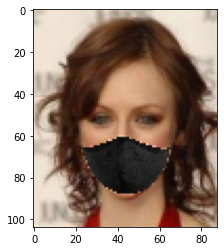

In [ ]:
plt.imshow(masked[0])

Define Helper Functions

In [ ]:
input_size = 33
label_size = 21
edge = int((input_size - label_size) / 2)

def normalize_image(image):
    return image / 255

def post_process_segmap(segmap):
    if DILATE_SEGMAPS:
        post_processed = np.array(segmap).astype(np.uint8)
        kernel = np.ones((3, 3), np.uint8)
        post_processed = cv.morphologyEx(post_processed, cv.MORPH_OPEN, kernel)
        kernel2 = np.ones((6, 3), np.uint8)
        post_processed = cv.dilate(post_processed, kernel2, iterations=1)
        return post_processed
    else:
        return segmap

def cut_out_mask(image, segmap):
    inverted_segmap = 1 - segmap[0]
    return image * (np.repeat(np.expand_dims(inverted_segmap, axis=-1), 3, axis=-1))

def merge_images(cutout_image, segmentation_map, autoencoder_output):
    inpainted_section = autoencoder_output[0] * (np.repeat(np.expand_dims(segmentation_map[0], axis=-1), 3, axis=-1))
    return cutout_image + inpainted_section

def to_batch(image):
    return np.expand_dims(image, 0)

def rgb2ycbcr(image):
    image = np.array(image)
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = image.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(image):
    image = np.array(image)
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = image.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

def shave(image, border):
    return image[border:-border, border:-border]

def pad(image, amount):
    padded = np.zeros((image.shape[0] + amount * 2, image.shape[1] + amount * 2, 3), dtype=image.dtype)
    for r in range(0, image.shape[0]):
        for c in range(0, image.shape[1]):
            padded[r + amount, c + amount, :] = image[r, c, :]
    return padded

def sr_preprocess(image):
    # image = rgb2ycbcr(image)
    image = image[:, :, 0].astype(np.float) / 255.0
    image = image.reshape(1, image.shape[0], image.shape[1], 1)
    return image

def sr_postprocess(image, original):
    output = image[0, :, :, 0] * 255
    output_image = np.zeros((output.shape[0], output.shape[1], 3))
    output_image[:, :, 0] = output
    output_image[:, :, 1:3] = shave(original[:, :, 1:3], edge)
    output_image = ycbcr2rgb(output_image)
    output_image = pad(output_image, 6)
    return output_image

Pass Images Through Models

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


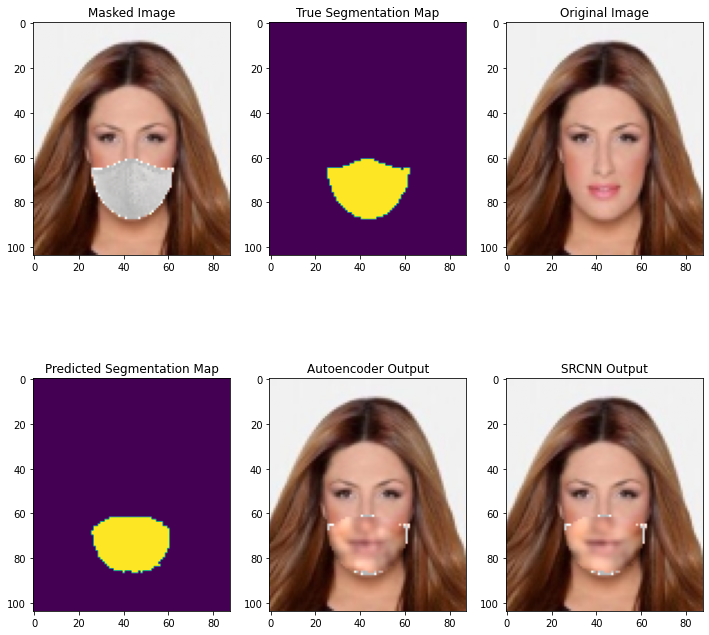

In [ ]:
index = 903 # 903

masked_image = to_batch(normalize_image(masked[index]))
true_segmap = segmaps[index]
original_image = unmasked[index]

predicted_segmap = tf.argmax(segmentation_model(masked_image), 3)
post_processed_segmap = to_batch(post_process_segmap(predicted_segmap[0]))

cut_out = to_batch(cut_out_mask(masked_image[0], post_processed_segmap))
inpainted_image = inpainting_model(cut_out)

inpainted_image_ycbcr = rgb2ycbcr(inpainted_image[0] * 255)
sr_input = sr_preprocess(inpainted_image_ycbcr)
sr_image = superresolution_model(sr_input)
sr_image = sr_postprocess(sr_image, inpainted_image_ycbcr)
figure = plt.figure(figsize=(12,12))

mask_plt = figure.add_subplot(231)
mask_plt.imshow(masked_image[0])

true_segmap_plt = figure.add_subplot(232)
true_segmap_plt.imshow(true_segmap)

original_plt = figure.add_subplot(233)
original_plt.imshow(original_image)

predicted_segmap_plt = figure.add_subplot(234)
predicted_segmap_plt.imshow(post_processed_segmap[0])

inpainted_plt = figure.add_subplot(235)
inpainted_plt.imshow(merge_images(cut_out[0], post_processed_segmap, inpainted_image))

superresolution_plt = figure.add_subplot(236)
superresolution_plt.imshow(merge_images(cut_out[0], post_processed_segmap, to_batch(sr_image / 255)))

mask_plt.title.set_text('Masked Image')
true_segmap_plt.title.set_text('True Segmentation Map')
original_plt.title.set_text('Original Image')
predicted_segmap_plt.title.set_text('Predicted Segmentation Map')
inpainted_plt.title.set_text('Autoencoder Output')
superresolution_plt.title.set_text('SRCNN Output')

In [ ]:
print(merge_images(cut_out[0], predicted_segmap, inpainted_image))

tf.Tensor(
[[[0.56078434 0.7254902  0.79607844]
  [0.36078432 0.5294118  0.61960787]
  [0.1882353  0.3372549  0.41960785]
  ...
  [0.01176471 0.12156863 0.33333334]
  [0.06666667 0.17254902 0.31764707]
  [0.29411766 0.37254903 0.47058824]]

 [[0.5529412  0.7254902  0.7882353 ]
  [0.3372549  0.5058824  0.5921569 ]
  [0.1882353  0.3372549  0.41568628]
  ...
  [0.01176471 0.12156863 0.32941177]
  [0.07058824 0.1764706  0.3254902 ]
  [0.3019608  0.38039216 0.47058824]]

 [[0.5411765  0.7176471  0.78039217]
  [0.31764707 0.49411765 0.5764706 ]
  [0.18431373 0.3372549  0.41568628]
  ...
  [0.01176471 0.12156863 0.3372549 ]
  [0.07450981 0.18431373 0.3254902 ]
  [0.3137255  0.3882353  0.4745098 ]]

 ...

 [[0.5254902  0.62352943 0.6431373 ]
  [0.52156866 0.61960787 0.6392157 ]
  [0.6039216  0.69411767 0.7176471 ]
  ...
  [0.6784314  0.8627451  0.90588236]
  [0.6117647  0.8        0.85490197]
  [0.6862745  0.87058824 0.92156863]]

 [[0.53333336 0.6392157  0.6666667 ]
  [0.53333336 0.63529414 0